# Notebook 3 — Chest X-Ray Pneumonia (CNN) — Grad-CAM for Human-in-the-Loop (Demo)

## Governance Framing & Intended Use
This notebook is a sanitized demonstration of explainability evidence (Grad-CAM)
and human-in-the-loop review in a high-risk medical imaging context.

- Intended use: decision support / alerting (demo only)
- Not intended for autonomous diagnosis or clinical deployment
- Focus: explainability + review workflow, not performance optimization

## Positioning / Scope (Portfolio Context)
This notebook demonstrates a CNN-based workflow (ResNet18) on a public chest X-ray dataset and uses Grad-CAM for **local visual explainability**.
It is intended as a **governance and human-in-the-loop demonstration** and does **not** constitute clinical performance claims.

**Key Deliverables**
- Performance snapshot (confusion matrix; optional ROC-AUC)
- Local explainability evidence: Grad-CAM overlays (TP + FP examples)
- Human review policy (confidence + explainability sanity checks)


## Environment Note (Sanitized)

Runtime environment and optional imaging tooling are omitted in this public version.
The focus is on governance evidence and explainability workflow.

## Data Access (Prerequisite)

Dataset: Kaggle chest-xray-pneumonia (public).
To keep this notebook sanitized, data acquisition steps and credentials are not included.

Expected local structure:
data/chest_xray/{train,val,test}/...


## Step 0 — Governance Framing & Intended Use


In [ ]:
import uuid
from datetime import datetime, timezone

run_id = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ") + "_" + uuid.uuid4().hex[:8]
print("run_id:", run_id)

## Step 1 — Dataset Structure Check (Evidence Hook)

This step verifies that dataset splits are isolated (train/val/test) and class folders are consistent.
The output listing is treated as an **A1 evidence snapshot** for traceability and auditability.

### Expected folder structure (conceptual)

```text
data/chest_xray/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── val/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── test/
    ├── NORMAL/
    └── PNEUMONIA/


### Evidence note (sanitized)

The absolute path in the snapshot below reflects the execution environment.
The governance-relevant evidence is the split separation and class directory structure,
not the specific filesystem prefix.




In [ ]:
# A1 evidence snapshot (captured once during controlled execution)
# NOTE: Do not re-run in the sanitized public version.
# The output below is retained as the evidence snapshot.
!find /content/data_pneumonia/chest_xray -maxdepth 2 -type d | sort



/content/data_pneumonia/chest_xray
/content/data_pneumonia/chest_xray/chest_xray
/content/data_pneumonia/chest_xray/chest_xray/test
/content/data_pneumonia/chest_xray/chest_xray/train
/content/data_pneumonia/chest_xray/chest_xray/val
/content/data_pneumonia/chest_xray/__MACOSX
/content/data_pneumonia/chest_xray/__MACOSX/chest_xray
/content/data_pneumonia/chest_xray/test
/content/data_pneumonia/chest_xray/test/NORMAL
/content/data_pneumonia/chest_xray/test/PNEUMONIA
/content/data_pneumonia/chest_xray/train
/content/data_pneumonia/chest_xray/train/NORMAL
/content/data_pneumonia/chest_xray/train/PNEUMONIA
/content/data_pneumonia/chest_xray/val
/content/data_pneumonia/chest_xray/val/NORMAL
/content/data_pneumonia/chest_xray/val/PNEUMONIA


## Step 2 — Data Loading (Sanitized)

Load the dataset using `torchvision.datasets.ImageFolder` and define a baseline
preprocessing pipeline. Exact preprocessing and augmentation details are intentionally simplified.

Baseline transforms:
- Convert grayscale images to 3-channel format (model compatibility)
- Resize images to **224×224** (ResNet input size)
- Convert images to tensors

The class mapping (`class_to_idx`) is explicitly inspected to ensure that labels are
**consistently interpreted throughout training and evaluation**.

**Purpose**  
Establish a baseline data ingestion pipeline and verify **label integrity and traceability**,
ensuring that downstream metrics and explanations can be correctly attributed
to the intended clinical classes.


In [2]:
!ls


artifacts  sample_data


In [1]:
import os
from datetime import datetime, timezone
import uuid

# 1) Create ONE run_id for this notebook run (used for filenames)
run_id = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ") + "_" + uuid.uuid4().hex[:8]
print("run_id:", run_id)

# 2) Create output folder for evidence snapshot
os.makedirs("artifacts/A1_dataset_structure", exist_ok=True)

# 3) Save the folder listing into a text file
snapshot_path = f"artifacts/A1_dataset_structure/{run_id}__A1__dataset_folder_structure.txt"

!find /content/data_pneumonia/chest_xray -maxdepth 3 -type d | sort > $snapshot_path

print("Saved snapshot to:", snapshot_path)


run_id: 20260126T223919Z_609b9998
find: ‘/content/data_pneumonia/chest_xray’: No such file or directory
Saved snapshot to: artifacts/A1_dataset_structure/20260126T223919Z_609b9998__A1__dataset_folder_structure.txt


In [ ]:
from torchvision import datasets, transforms

DATA_DIR = "/content/data_pneumonia/chest_xray"

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

full_train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_tf)
test_ds = datasets.ImageFolder(f"{DATA_DIR}/test", transform=eval_tf)

print("Classes:", full_train_ds.classes)
print("Class mapping:", full_train_ds.class_to_idx)


Classes: ['NORMAL', 'PNEUMONIA']
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


## Step 3 — Model Training (Minimal & Reproducible)

Train a convolutional neural network using a **fixed-size subset** of the training data. Hyperparameter tuning is intentionally omitted.

Design choices:
- Subset-based training (e.g. 500 images)
- Limited number of epochs
- Pretrained ResNet architecture

This setup is **intentional**:
the goal is not model optimization, but to obtain a **stable and interpretable model**
suitable for explainability and governance demonstrations.

**Purpose**  
Demonstrate a realistic training setup while keeping runtime predictable and
avoiding over-optimization that would distract from governance objectives.




In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- fixed subset for reproducibility ----
torch.manual_seed(42)
np.random.seed(42)

subset_size = 500
indices = np.random.choice(len(full_train_ds), size=subset_size, replace=False)
train_ds_small = Subset(full_train_ds, indices)

train_loader = DataLoader(
    train_ds_small,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # often faster & more stable for demos
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# ---- model ----
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(full_train_ds.classes))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ---- training loop (short by design) ----
EPOCHS = 2

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


Epoch 1/2 - Loss: 4.4949
Epoch 2/2 - Loss: 0.7182


## Step 4 — Model Evaluation & Error Analysis

Evaluate the trained model on a held-out test set and report baseline classification metrics. False positives are prioritized for review in high-risk settings.

Reported metrics:
- Confusion Matrix
- Accuracy

This step is **not** used for hyperparameter tuning.  
Instead, it establishes a transparent baseline and clarifies the model’s error profile,
which later informs explainability review and governance decisions.

**Purpose**  
Provide an auditable baseline performance reference on unseen data.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)


Confusion Matrix:
 [[ 15 219]
 [  0 390]]
Accuracy: 0.6490384615384616


## Step 5 — Error Characterization for Explainability

Generate a classification report (precision/recall/F1) to understand which class is harder to predict.

This supports governance interpretation:
- High recall but low precision may indicate an “alarm-happy” model (many false positives).
- Low recall may indicate missed cases (higher clinical risk).

**Purpose**  
Characterize errors and justify the need for human oversight and explainability review.


In [ ]:
from sklearn.metrics import classification_report

def run_eval(loader):
    model.eval()
    all_y, all_p = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            all_y.append(y.cpu().numpy())
            all_p.append(p.cpu().numpy())
    all_y = np.concatenate(all_y)
    all_p = np.concatenate(all_p)
    acc = (all_y == all_p).mean()
    return acc, all_y, all_p

test_acc, y_true, y_pred = run_eval(test_loader)
print(classification_report(y_true, y_pred, target_names=test_ds.classes))



              precision    recall  f1-score   support

      NORMAL       1.00      0.06      0.12       234
   PNEUMONIA       0.64      1.00      0.78       390

    accuracy                           0.65       624
   macro avg       0.82      0.53      0.45       624
weighted avg       0.78      0.65      0.53       624



## Step 6 — Case Selection for Explainability (TP / FP)

Select representative test cases for explainability review:
- **True Positive**: correctly predicted PNEUMONIA
- **False Positive**: NORMAL predicted as PNEUMONIA

These cases are used to generate Grad-CAM heatmaps and support a human review workflow.

False positives are prioritized for review in high-risk settings.

**Purpose**  
Create a traceable link between quantitative evaluation and qualitative explanations.




In [ ]:
# -----------------------------
# Case Selection for Grad-CAM
# Purpose: collect TP/FP examples for human-reviewable explanations
# -----------------------------

import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

pneumonia_idx = full_train_ds.class_to_idx.get("PNEUMONIA", 1)

all_probs, all_preds, all_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)
        probs = torch.softmax(logits, dim=1)[:, pneumonia_idx]
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.detach().cpu().numpy().tolist())
        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=test_ds.classes))

all_probs  = np.array(all_probs)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# use pneumonia_idx consistently
TP = np.where((all_labels == pneumonia_idx) & (all_preds == pneumonia_idx))[0]
FP = np.where((all_labels != pneumonia_idx) & (all_preds == pneumonia_idx))[0]
FN = np.where((all_labels == pneumonia_idx) & (all_preds != pneumonia_idx))[0]
TN = np.where((all_labels != pneumonia_idx) & (all_preds != pneumonia_idx))[0]

print(f"TP={len(TP)}, FP={len(FP)}, FN={len(FN)}, TN={len(TN)}")

tp_idx = int(TP[0]) if len(TP) else None
fp_idx = int(FP[0]) if len(FP) else None

print("Example TP index:", tp_idx)
print("Example FP index:", fp_idx)


Confusion Matrix:
 [[ 15 219]
 [  0 390]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      0.06      0.12       234
   PNEUMONIA       0.64      1.00      0.78       390

    accuracy                           0.65       624
   macro avg       0.82      0.53      0.45       624
weighted avg       0.78      0.65      0.53       624

TP=390, FP=219, FN=0, TN=15
Example TP index: 234
Example FP index: 0


## Step 7 — Explainability (Grad-CAM Heatmaps)

Apply Grad-CAM to visualize which image regions contributed to the model’s prediction.

We document at least:
- One **True Positive** example (clinically plausible focus expected)
- One **False Positive** example (often highlights artefacts, borders, or acquisition issues)

To improve interpretability:
- Use an earlier ResNet layer (higher CAM resolution)
- Apply mild smoothing to reduce blocky artefacts
- Grad-CAM is supportive evidence for human review, not proof of clinical validity.

**Purpose**  
Enable human reviewers to challenge and contextualize model outputs,
supporting auditability and human oversight.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/tmp/ipython-input-2631757979.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  run_id = datetime.datetime.utcnow().strftime("%Y%m%dT%H%M%SZ") + "_" + uuid.uuid4().hex[:8]


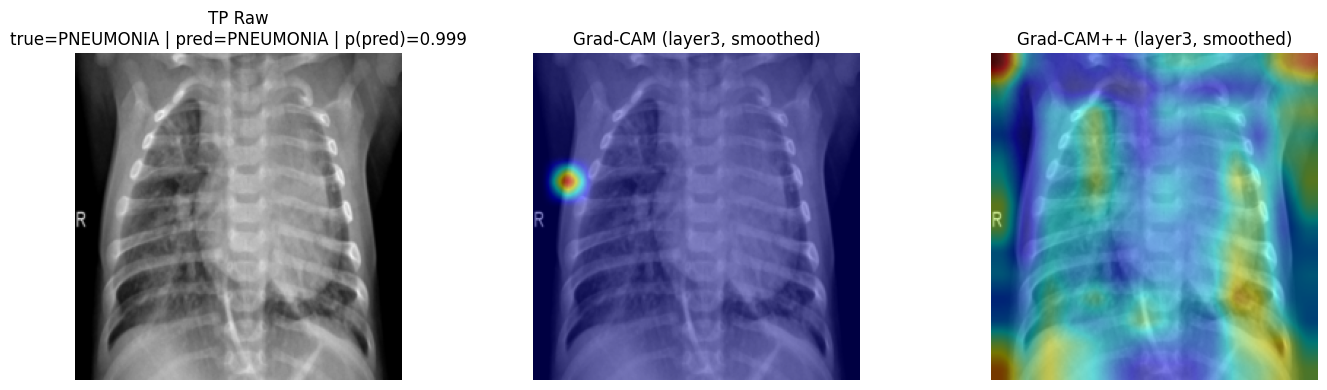

Saved Grad-CAM artifact: artifacts/gradcam/20260125T223717Z_62e949f8_TP_idx234_true-PNEUMONIA_pred-PNEUMONIA.png


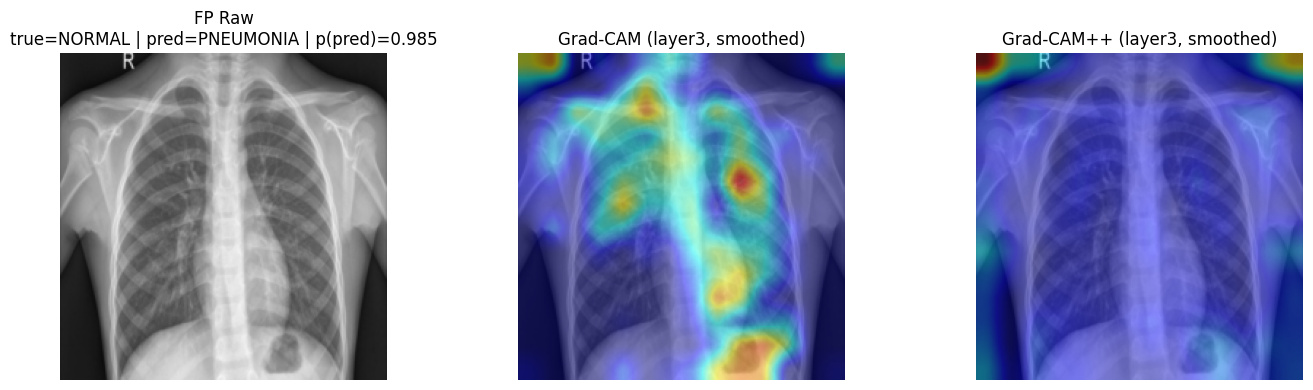

Saved Grad-CAM artifact: artifacts/gradcam/20260125T223717Z_62e949f8_FP_idx0_true-NORMAL_pred-PNEUMONIA.png
TP artifact: artifacts/gradcam/20260125T223717Z_62e949f8_TP_idx234_true-PNEUMONIA_pred-PNEUMONIA.png
FP artifact: artifacts/gradcam/20260125T223717Z_62e949f8_FP_idx0_true-NORMAL_pred-PNEUMONIA.png


In [ ]:
# -----------------------------
# Grad-CAM (Save TP/FP Heatmap Artifacts)
# Purpose: Generate and save human-reviewable visual explanations
# -----------------------------

!pip -q install grad-cam

import os, uuid, datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()

# -----------------------------
# Output folder
# -----------------------------
OUT_DIR = "artifacts/gradcam"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# Helpers
# -----------------------------
def tensor_to_rgb_no_norm(img_tensor):
    """
    Convert torch tensor (C,H,W) in [0,1] to RGB float image [0,1].
    Assumes your transform did NOT apply ImageNet normalization.
    """
    img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    return img

def smooth_cam(grayscale_cam, sigma=2.0):
    cam_img = grayscale_cam.astype(np.float32)
    cam_img = cv2.GaussianBlur(cam_img, (0, 0), sigmaX=sigma)
    cam_img = np.clip(cam_img, 0, 1)
    return cam_img

def get_test_example(dataset, idx):
    x, y = dataset[idx]  # ImageFolder returns (tensor, label)
    return x, int(y)

# -----------------------------
# Choose target layer (higher-res CAM)
# layer3[-1] -> 14x14 CAM (less blocky than layer4[-1])
# -----------------------------
target_layers = [model.layer3[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
cam_pp = GradCAMPlusPlus(model=model, target_layers=target_layers)

# -----------------------------
# Main: generate & save a 3-panel artifact
# -----------------------------
def save_gradcam_artifact(dataset, idx, tag="TP"):
    if idx is None:
        print(f"[{tag}] idx is None (no sample available).")
        return None

    x, y_true = get_test_example(dataset, idx)
    x_in = x.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(x_in)
        pred = int(torch.argmax(logits, dim=1)[0].item())
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()

    # target = predicted class (explains the model's actual decision)
    targets = [ClassifierOutputTarget(pred)]

    # CAM maps
    grayscale_cam = cam(input_tensor=x_in, targets=targets)[0]
    grayscale_cam_pp = cam_pp(input_tensor=x_in, targets=targets)[0]

    # smooth to reduce block artifacts
    grayscale_cam_s = smooth_cam(grayscale_cam, sigma=2.0)
    grayscale_cam_pp_s = smooth_cam(grayscale_cam_pp, sigma=2.0)

    # base image
    rgb_img = tensor_to_rgb_no_norm(x)

    # overlays
    overlay1 = show_cam_on_image(rgb_img, grayscale_cam_s, use_rgb=True, image_weight=0.55)
    overlay2 = show_cam_on_image(rgb_img, grayscale_cam_pp_s, use_rgb=True, image_weight=0.55)

    # labels
    class_names = dataset.classes
    true_name = class_names[y_true] if y_true < len(class_names) else str(y_true)
    pred_name = class_names[pred] if pred < len(class_names) else str(pred)

    # file name (audit-friendly)
    fname = f"{run_id}_{tag}_idx{idx}_true-{true_name}_pred-{pred_name}.png"
    fpath = os.path.join(OUT_DIR, fname)

    # plot + save
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f"{tag} Raw\ntrue={true_name} | pred={pred_name} | p(pred)={probs[pred]:.3f}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay1)
    plt.title("Grad-CAM (layer3, smoothed)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay2)
    plt.title("Grad-CAM++ (layer3, smoothed)")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(fpath, dpi=200, bbox_inches="tight")
    plt.show()

    print(f"Saved Grad-CAM artifact: {fpath}")
    return fpath

# -----------------------------
# Save TP / FP artifacts
# (tp_idx / fp_idx come from Step 9)
# -----------------------------
tp_path = save_gradcam_artifact(test_ds, tp_idx, tag="TP")
fp_path = save_gradcam_artifact(test_ds, fp_idx, tag="FP")

print("TP artifact:", tp_path)
print("FP artifact:", fp_path)


**Interpretation note**

Grad-CAM heatmaps visualise which image regions contributed most to the model output.
They are provided to support case-based human review and should not be interpreted
as clinical localisation or diagnostic ground truth.

In false positive cases, highlighted regions may correspond to artefacts,
image boundaries or acquisition-related patterns, underlining the necessity
of expert validation and override.


## Step 8 — Record-Keeping & Audit Trail (Art. 12 Spirit)

For each run, a machine-readable audit log is generated, capturing:
- Dataset and split identifiers
- Model configuration
- Evaluation metrics
- Explainability artefacts
- Bias/robustness signals
- Review policy outcomes

Explainability artefacts (e.g. Grad-CAM images) are stored with
traceable filenames that encode run ID, evidence category (C3),
error type (TP/FP), and true/predicted labels.

**Purpose**  
Provide an auditable, traceable evidence trail that bridges
a notebook-based demo and regulatory inspection requirements.



In [ ]:
import json
from datetime import datetime, timezone
import os

# -----------------------------
# Audit logging (JSONL)
# Purpose: Record auditable governance evidence per run
# -----------------------------
os.makedirs("audit", exist_ok=True)

audit_record = {
    "run_id": run_id,
    "timestamp": datetime.now(timezone.utc).isoformat(),
    "project": "EU AI Act Governance Demo",
    "project_id": "Project-1-Pneumonia-CNN",
    "model": {
        "type": "CNN",
        "architecture": "ResNet18 (pretrained, demo setup)",
        "task": "pneumonia classification (medical imaging demo)"
    },
    "dataset": {
        "source": "Kaggle (public benchmark): chest-xray-pneumonia",
        "split": "test",
        "expected_structure": "data/chest_xray/{train,val,test}/(NORMAL|PNEUMONIA)"
    },
    "performance_snapshot": {
        "accuracy": float(acc),
        "confusion_matrix": cm.tolist()
    },
    "explainability": {
        "method": "Grad-CAM / Grad-CAM++",
        "artifacts": [tp_path, fp_path]
    },
    "human_oversight": {
        "review_required": True,
        "trigger": "False positive example included for review workflow demonstration",
        "policy_reference": "P4_human_oversight_review_triggers.md"
    },
    "notes": (
        "This audit record is generated as a governance evidence artifact for demonstration purposes. "
        "It does not represent a production deployment log."
    )
}

with open("audit/audit_log.jsonl", "a", encoding="utf-8") as f:
    f.write(json.dumps(audit_record) + "\n")

print("Audit record written:", run_id)


Audit record written: 933d35a8-5a21-4c07-a002-1e709d6de3ff


/tmp/ipython-input-2656389713.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),
